# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import boto3
import os
import csv
import sagemaker
from PIL import Image
import io
import json
import requests
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, FrameworkProfile, DebuggerHookConfig, ProfilerConfig
from smdebug.trials import create_trial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


[2023-06-24 23:18:40.809 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [4]:
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket= session.default_bucket()
region = session.boto_region_name

In [5]:
print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-026603419603
AWS Region: us-east-1
RoleArn: arn:aws:iam::026603419603:role/service-role/AmazonSageMaker-ExecutionRole-20230522T160146


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [6]:
def create_metadata(database_path):
    with open(os.path.join(database_path, 'meta.csv'), 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Filename'])
        for root, dirs, files in os.walk(database_path):
            files.sort()
            for file in files:
                if file.lower().endswith('.jpg'):
                    classification_id = int(root.split("/")[2].split(".")[0])-1
                    rel_path = os.path.join(root, file)
                    row = [classification_id, rel_path]
                    writer.writerow(row)
    print('Creating metadata completed for file', os.path.join(database_path, 'meta.csv'))
                    
create_metadata('dogImages/test')
create_metadata('dogImages/train')
create_metadata('dogImages/valid')

Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata completed for file dogImages/valid/meta.csv


In [7]:
database_path = 'dogImages'
def create_labels_map(database_path):
    output_filename = os.path.join(database_path, 'labels.csv')
    with open(output_filename, 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Breed name'])
        for root, dirs, files in os.walk(os.path.join(database_path, 'test')):
            dirs.sort()
            for directories in dirs:
                splitted_dir_name = directories.split(".")
                if (len(splitted_dir_name) == 2 and len(splitted_dir_name[0])>0):
                    splitted_dir_name[0] = int(splitted_dir_name[0]) - 1
                    writer.writerow(splitted_dir_name)
            break
    print('Created path', output_filename)
    
create_labels_map('dogImages')

Created path dogImages/labels.csv


In [8]:
# Print statistics about the dataset
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')
valid_meta = pd.read_csv('dogImages/valid/meta.csv')
train_meta = pd.read_csv('dogImages/train/meta.csv')

print('There are %d total dog categories.' % len(labels_map))
print('There are %s total dog images.\n' % str(len(test_meta)+len(valid_meta)+len(train_meta)))
print('There are %d training dog images.' % len(train_meta))
print('There are %d validation dog images.' % len(valid_meta))
print('There are %d test dog images.'% len(test_meta))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [9]:
test_meta

,Id,Filename
0,113,dogImages/test/114.Otterhound/Otterhound_07394...
1,113,dogImages/test/114.Otterhound/Otterhound_07405...
2,113,dogImages/test/114.Otterhound/Otterhound_07430...
3,113,dogImages/test/114.Otterhound/Otterhound_07435...
4,109,dogImages/test/110.Norwegian_lundehund/Norwegi...
...,...,...
831,6,dogImages/test/007.American_foxhound/American_...
832,6,dogImages/test/007.American_foxhound/American_...
833,6,dogImages/test/007.American_foxhound/American_...
834,6,dogImages/test/007.American_foxhound/American_...


In [10]:
labels_map

,Id,Breed name
0,0,Affenpinscher
1,1,Afghan_hound
2,2,Airedale_terrier
3,3,Akita
4,4,Alaskan_malamute
...,...,...
128,128,Tibetan_mastiff
129,129,Welsh_springer_spaniel
130,130,Wirehaired_pointing_griffon
131,131,Xoloitzcuintli


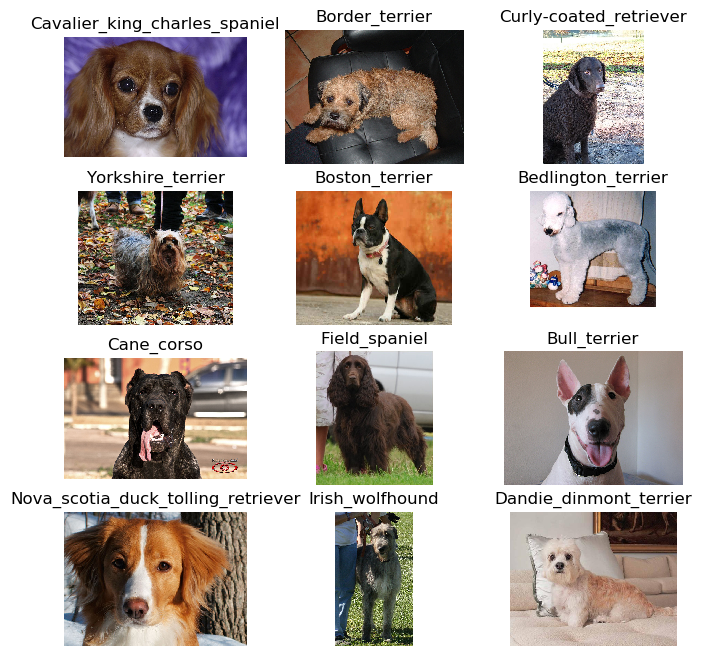

In [14]:
# Plot some of the data
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(test_meta))
    img_path = test_meta.iloc[sample_idx, 1]
    label_id = test_meta.iloc[sample_idx, 0]
    label = labels_map.iloc[int(label_id), 1]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(img_path).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_images.png')

In [8]:
os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/dogImages/"
!aws s3 cp dogImages ${DATABASE_PATH} --recursive

upload: dogImages/.ipynb_checkpoints/labels-checkpoint.csv to s3://sagemaker-us-east-1-026603419603/dogImages/.ipynb_checkpoints/labels-checkpoint.csv
upload: dogImages/labels.csv to s3://sagemaker-us-east-1-026603419603/dogImages/labels.csv
upload: dogImages/test/.ipynb_checkpoints/meta-checkpoint.csv to s3://sagemaker-us-east-1-026603419603/dogImages/test/.ipynb_checkpoints/meta-checkpoint.csv
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-026603419603/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-026603419603/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://sagemaker-us-east-1-026603419603/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-026603419603/dogIma

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
# Directory path
directory = "model"

# Create 'model' folder if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
    print("Folder 'model' created successfully.")

# Directory path for model_train
directory_train = "model_train"

# Create 'model_train' folder if it doesn't exist
if not os.path.exists(directory_train):
    os.makedirs(directory_train)
    print("Folder 'model_train' created successfully.")

In [7]:
os.environ['MODEL_DIR']="s3://"+ bucket+ "/model/" # where model will be stored
os.environ['TRAIN_MODEL_DIR']="s3://"+ bucket+ "/model_train/" # where model will be stored

In [28]:
# Copy the folder to S3
!aws s3api put-object --bucket sagemaker-us-east-1-026603419603 --key model/

{
    "ETag": "\"d41d8cd98f00b204e9800998ecf8427e\"",
    "ServerSideEncryption": "AES256"
}


In [29]:
!aws s3api put-object --bucket sagemaker-us-east-1-026603419603 --key model_train/

{
    "ETag": "\"d41d8cd98f00b204e9800998ecf8427e\"",
    "ServerSideEncryption": "AES256"
}


In [8]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [9]:
! python hpo.py

Traceback (most recent call last):
  File "hpo.py", line 2, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


In [10]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [11]:
# TODO: Fit your HP Tuner
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']= "s3://"+ bucket+ "/dogImages/model/" # where model will be stored

In [12]:
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
..........................................................................................................................................................................!


In [7]:
# BetterTrainingJobName='pytorch-training-230616-2159-002-c4a9c0e7'
# my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)


2023-06-16 22:37:04 Starting - Preparing the instances for training
2023-06-16 22:37:04 Downloading - Downloading input data
2023-06-16 22:37:04 Training - Training image download completed. Training in progress.
2023-06-16 22:37:04 Uploading - Uploading generated training model
2023-06-16 22:37:04 Completed - Resource released due to keep alive period expiry


In [13]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-06-24 23:36:07 Starting - Preparing the instances for training
2023-06-24 23:36:07 Downloading - Downloading input data
2023-06-24 23:36:07 Training - Training image download completed. Training in progress.
2023-06-24 23:36:07 Uploading - Uploading generated training model
2023-06-24 23:36:07 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"60"',
 'lr': '0.18096406880426816',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-06-24-23-23-10-682"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-026603419603/pytorch-training-2023-06-24-23-23-10-682/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "2",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [15]:
# TODO: Create and fit an estimator
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr']}
print(hyperparameters)

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="debugger-profiler-project3",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=hook_config,
)

{'batch-size': 60, 'lr': '0.18096406880426816'}


In [16]:
# TODO: Plot a debugging output.S
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']= "s3://"+ bucket+ "/model_train/" 
estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: debugger-profiler-project3-2023-06-24-23-41-16-734


Using provided s3_resource
2023-06-24 23:41:17 Starting - Starting the training job...
2023-06-24 23:41:42 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-06-24 23:42:44 Downloading - Downloading input data.........
2023-06-24 23:44:04 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-24 23:44:28,534 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-24 23:44:28,537 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-24 23:44:28,546 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-24 23:44:28,550 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-06-24 23:44:28,733 sagemaker-training-toolkit

In [27]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug Path:', debug_artifacts_path)
print('Job name:', job_name)
print('Client: ',client )
print('Trial', trial)

Debug Path: s3://sagemaker-us-east-1-026603419603/debugger-profiler-project3-2023-06-24-23-41-16-734/debug-output
Job name: debugger-profiler-project3-2023-06-24-23-41-16-734
Client:  <botocore.client.SageMaker object at 0x7fede0b6b850>
Trial [2023-06-25 00:03:38.388 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-06-25 00:03:39.409 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO trial.py:210] Loaded all steps
<smdebug.trials.s3_trial.S3Trial object at 0x7fede1b06d90>:(
    name=debug-output,
    path=s3://sagemaker-us-east-1-026603419603/debugger-profiler-project3-2023-06-24-23-41-16-734/debug-output/,
    steps=[0, 12],
    collections=['gradients', 'all', 'losses', 'biases', 'default', 'weights'],
    tensor_names=['CrossEntropyLoss_output_0'],
)


In [21]:
print("Tensor Names: ",trial.tensor_names())

Tensor Names:  ['CrossEntropyLoss_output_0']


In [30]:
from smdebug.core.modes import ModeKeys

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


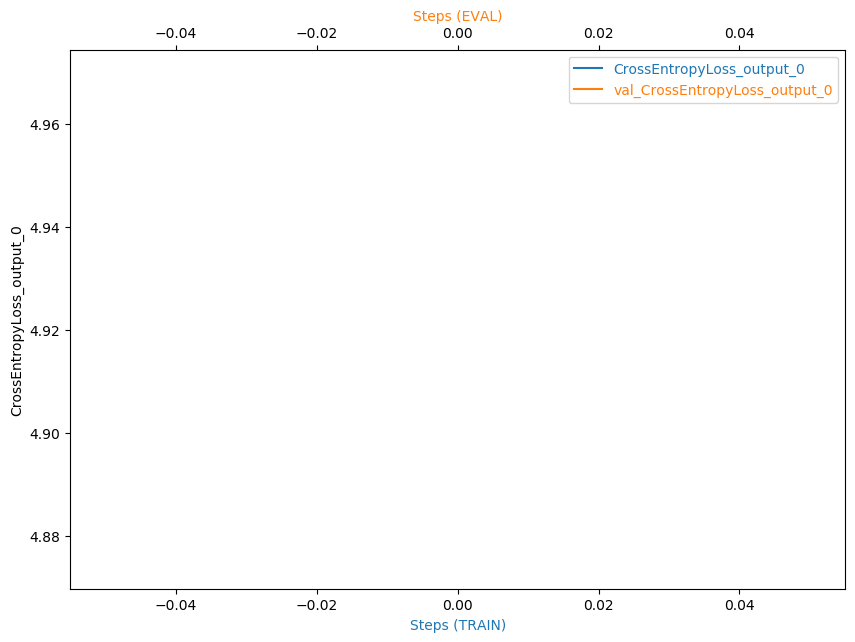

In [32]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [33]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-06-24 23:54:38     364393 debugger-profiler-project3-2023-06-24-23-41-16-734/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-06-24 23:54:38     211444 debugger-profiler-project3-2023-06-24-23-41-16-734/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-06-24 23:54:33        192 debugger-profiler-project3-2023-06-24-23-41-16-734/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-06-24 23:54:33        200 debugger-profiler-project3-2023-06-24-23-41-16-734/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-06-24 23:54:33       1874 debugger-profiler-project3-2023-06-24-23-41-16-734/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-06-24 23:54:33        127 debugger-profiler-project3-2023-06-24-23-41-16-734/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-06-24 23:54:33        199 debugger-profiler-project3-2023-06-

In [34]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [35]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [52]:
model_location=estimator.model_data
py_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [53]:
# TODO: Deploy your model to an endpoint
predictor = py_model.deploy(initial_instance_count=1, instance_type='ml.m5.large',
                            model_server_config={'MaxResponseSize': '4096'})  # Adjust the value as needed

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-026603419603/debugger-profiler-project3-2023-06-24-23-41-16-734/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-026603419603/pytorch-inference-2023-06-25-00-29-07-329/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-06-25-00-29-14-835
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-06-25-00-29-15-630
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-06-25-00-29-15-630


----!

In [56]:
# TODO: Run an prediction on the endpoint
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)
image = Image.open(io.BytesIO(img_bytes))

In [57]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Response received from the primary container has headers with length greater than 4096 bytes. Reduce the length of your container's response headers and update your endpoint.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-06-25-00-29-15-630 in account 026603419603 for more information.

In [43]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
print("Response from Endpoint: ", response)
labeled_predictions = list(zip(range(133), response[0]))
labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Response received from the primary container has headers with length greater than 4096 bytes. Reduce the length of your container's response headers and update your endpoint.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-06-25-00-07-36-140 in account 026603419603 for more information.

In [39]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-06-17-03-31-26-945
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-06-17-03-31-26-945
